#Load Image

In [ ]:
!pip install opencv-python
!pip install opencv-python-headless numpy

In [ ]:
import os
import time
from PIL import Image
import cv2
import skimage.draw as drw
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

%matplotlib inline
import matplotlib
from google.colab.patches import cv2_imshow
import statistics

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Nannofossils_Dataset(1437)"

In [ ]:
%cd /content/gdrive/MyDrive/Nannofossils_Dataset(1437)/images_test

/content/gdrive/MyDrive/Nannofossils_Dataset(1437)/images_test


In [ ]:
!ls

'image(100).jpg'  'image(153).jpg'  'image(205).jpg'  'image(258).jpg'	'image(50).jpg'
'image(101).jpg'  'image(154).jpg'  'image(206).jpg'  'image(259).jpg'	'image(51).jpg'
'image(102).jpg'  'image(155).jpg'  'image(207).jpg'  'image(25).jpg'	'image(52).jpg'
'image(103).jpg'  'image(156).jpg'  'image(208).jpg'  'image(260).jpg'	'image(53).jpg'
'image(104).jpg'  'image(157).jpg'  'image(209).jpg'  'image(261).jpg'	'image(54).jpg'
'image(105).jpg'  'image(158).jpg'  'image(20).jpg'   'image(262).jpg'	'image(55).jpg'
'image(106).jpg'  'image(159).jpg'  'image(210).jpg'  'image(263).jpg'	'image(56).jpg'
'image(107).jpg'  'image(15).jpg'   'image(211).jpg'  'image(264).jpg'	'image(57).jpg'
'image(108).jpg'  'image(160).jpg'  'image(212).jpg'  'image(265).jpg'	'image(58).jpg'
'image(109).jpg'  'image(161).jpg'  'image(213).jpg'  'image(266).jpg'	'image(59).jpg'
'image(10).jpg'   'image(162).jpg'  'image(214).jpg'  'image(267).jpg'	'image(5).jpg'
'image(110).jpg'  'image(163).jpg'  'image(21

In [ ]:
# Membuat variabel yang berbeda pada setiap iterasi
ori_varString = []
for i in range(287):
  img_bgr = "image("+ str(i+1) +").jpg"
  globals()[f"image_ori{i+1}"] = cv2.imread(img_bgr)
  ori_varString.append("image_ori"+str(i+1))
# Mengubah setiap string menjadi array
ori_var = [eval(string) for string in ori_varString]

In [ ]:
def show_images(images_var,title):
    num_rows = 2
    num_cols = 4
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 8))
    fig.suptitle(title)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images_var[i])
        ax.set_title(f"Image {i+1}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Membuat variabel yang berbeda pada setiap iterasi
ori_rgb_varString = []
for i in range(287):
  img_rgb = ori_var[i]
  globals()[f"image_ori_rgb{i+1}"] = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
  ori_rgb_varString.append("image_ori_rgb"+str(i+1))
# Mengubah setiap string menjadi array
ori_rgb_var = [eval(string) for string in ori_rgb_varString]

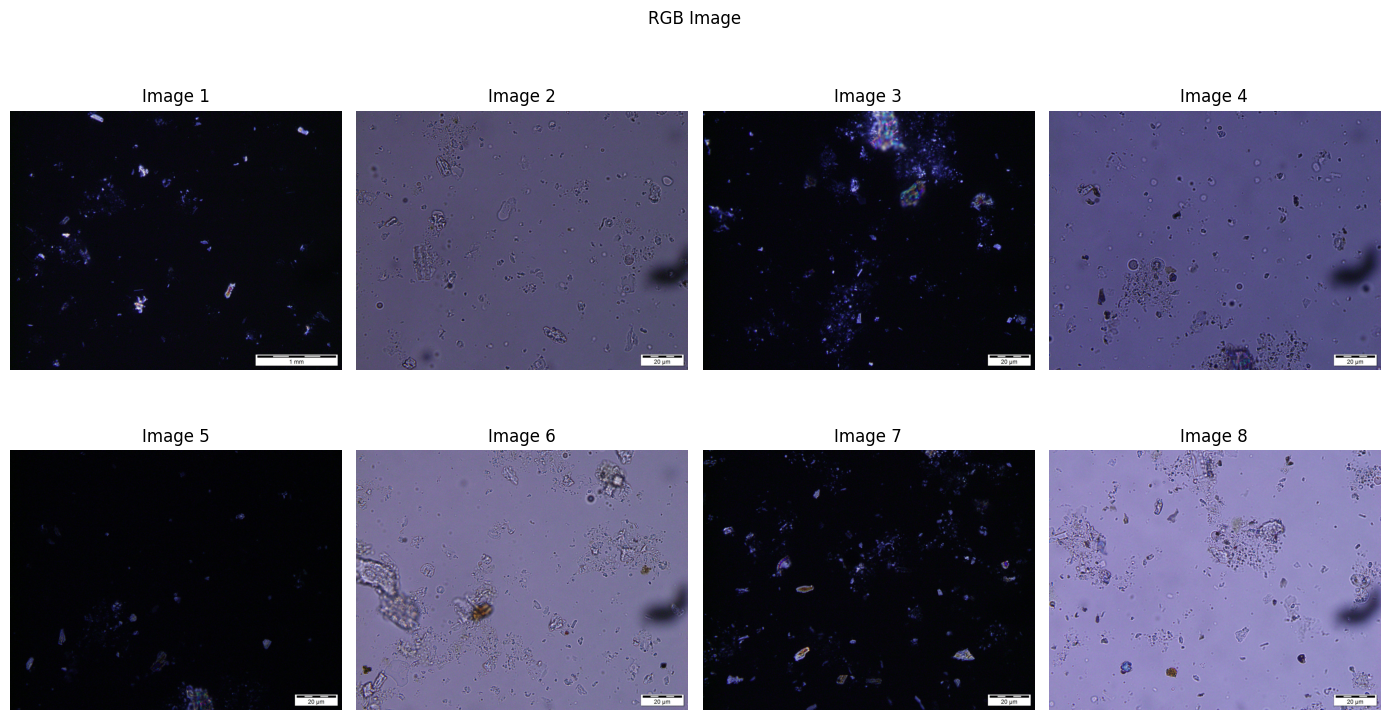

In [ ]:
show_images(ori_rgb_var, "RGB Image")

In [ ]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

#HSRGAN

In [ ]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [ ]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [ ]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model = hub.load(SAVED_MODEL_PATH)

In [ ]:
def low2highImg(image, modelTrain = model):
  h_res_img = preprocess_image(image)
  low_res_img = downscale_image(tf.squeeze(h_res_img))
  high_res_img = modelTrain(low_res_img)
  high_res_img = tf.squeeze(high_res_img)
  return high_res_img

In [ ]:
# Membuat variabel yang berbeda pada setiap iterasi
ori2_varString = []
for i in range(287):
  img_bgr = "image("+ str(i+1) +").jpg"
  globals()[f"image_ori2{i+1}"] = img_bgr
  ori2_varString.append("image_ori2"+str(i+1))
# Mengubah setiap string menjadi array
ori2_var = [eval(string) for string in ori2_varString]

In [ ]:
# Membuat variabel yang berbeda pada setiap iterasi
ori_high_res_varString = []
for i in range(287):
  img_ori = ori2_var[i]
  globals()[f"highResImg{i+1}"] = low2highImg(img_ori)
  ori_high_res_varString.append("highResImg"+str(i+1))
# Mengubah setiap string menjadi array
ori_high_res_var = [eval(string) for string in ori_high_res_varString]

In [ ]:
def show_images2(images_var,title):
    num_rows = 2
    num_cols = 4
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 8))
    fig.suptitle(title)

    for i, ax in enumerate(axes.flat):
        image = images_var[i]
        image = tf.clip_by_value(image, 0, 255)
        image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
        ax.imshow(image)
        ax.set_title(f"Image {i+1}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

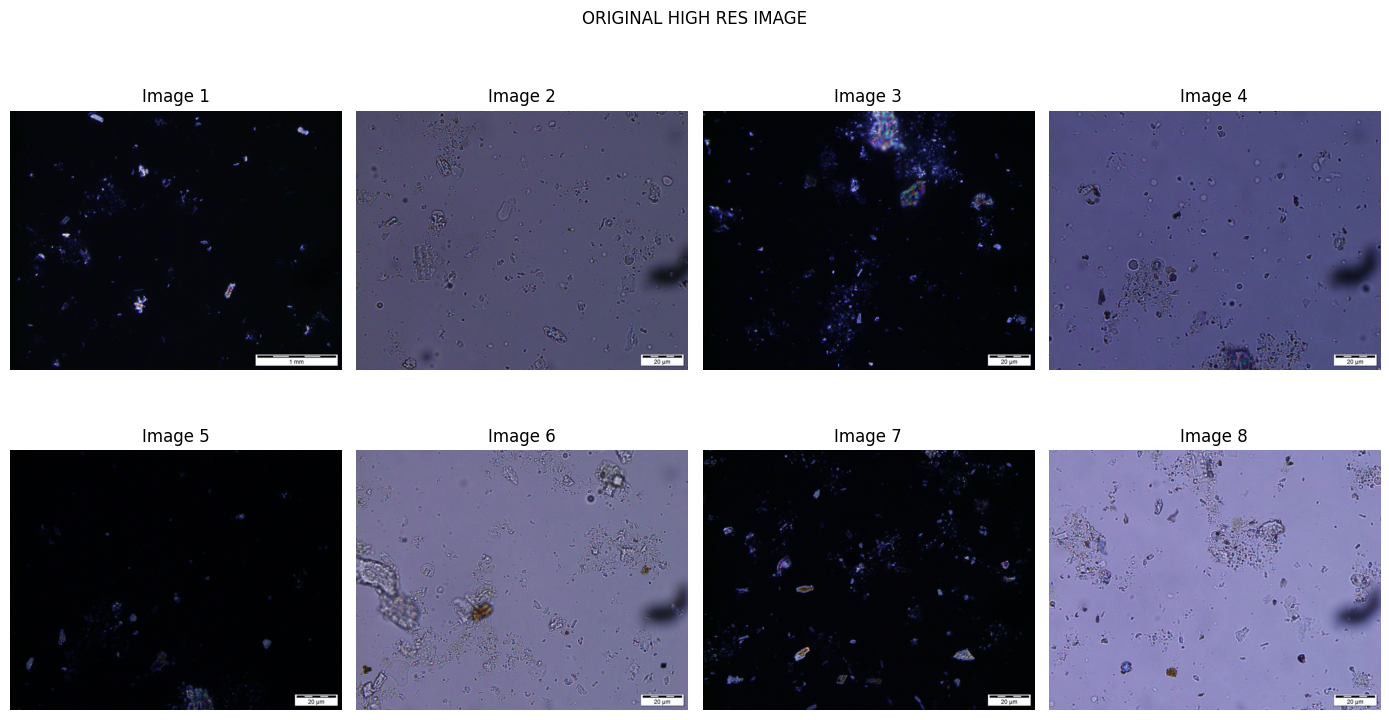

In [ ]:
show_images2(ori_high_res_var, "ORIGINAL HIGH RES IMAGE")

In [ ]:
from PIL import Image
from numpy import asarray
output_HRes = "/content/gdrive/MyDrive/Nannofossils_Dataset(1437)/HRes_test/"
for i in range(287):
  image_high_res = ori_high_res_var[i]
  numpydata = asarray(image_high_res)
  image_high_res2 = cv2.cvtColor(numpydata, cv2.COLOR_BGR2RGB)
  cv2.imwrite(f"{output_HRes}image_HRes({str(i+1)}).jpg",image_high_res2)

#Invert Image

In [ ]:
def invert_image(img, plot_hist=False):
    # Invert the image
    inverted_img = 255 - img

    if plot_hist:
        for i in range(inverted_img.shape[2]):
            plt.hist(inverted_img[:, :, i].ravel(), bins=256, alpha=0.5, label=f'Channel {i}')
        plt.title('Histogram of Inverted Image')
        plt.legend()
        plt.show()

    return inverted_img

In [ ]:
path_HRes = "/content/gdrive/MyDrive/Nannofossils_Dataset(1437)/HRes_test/"
HRes_ori_varString = []
for i in range(287):
  HRes_img_bgr = (path_HRes+"image_HRes(" + str(i+1) + ").jpg")
  globals()[f"high_res_img{i+1}"] = cv2.imread(HRes_img_bgr)
  HRes_ori_varString.append("high_res_img"+str(i+1))
# Mengubah setiap string menjadi array
HRes_ori_var = [eval(string) for string in HRes_ori_varString]

In [ ]:
Hres_varString = []
for i in range(287):
  Hres_img_rgb = HRes_ori_var[i]
  globals()[f"image_Hres_ori_rgb{i+1}"] = cv2.cvtColor(Hres_img_rgb, cv2.COLOR_BGR2RGB)
  Hres_varString.append("image_Hres_ori_rgb"+str(i+1))
# Mengubah setiap string menjadi array
Hres_ori_rgb_var = [eval(string) for string in Hres_varString]

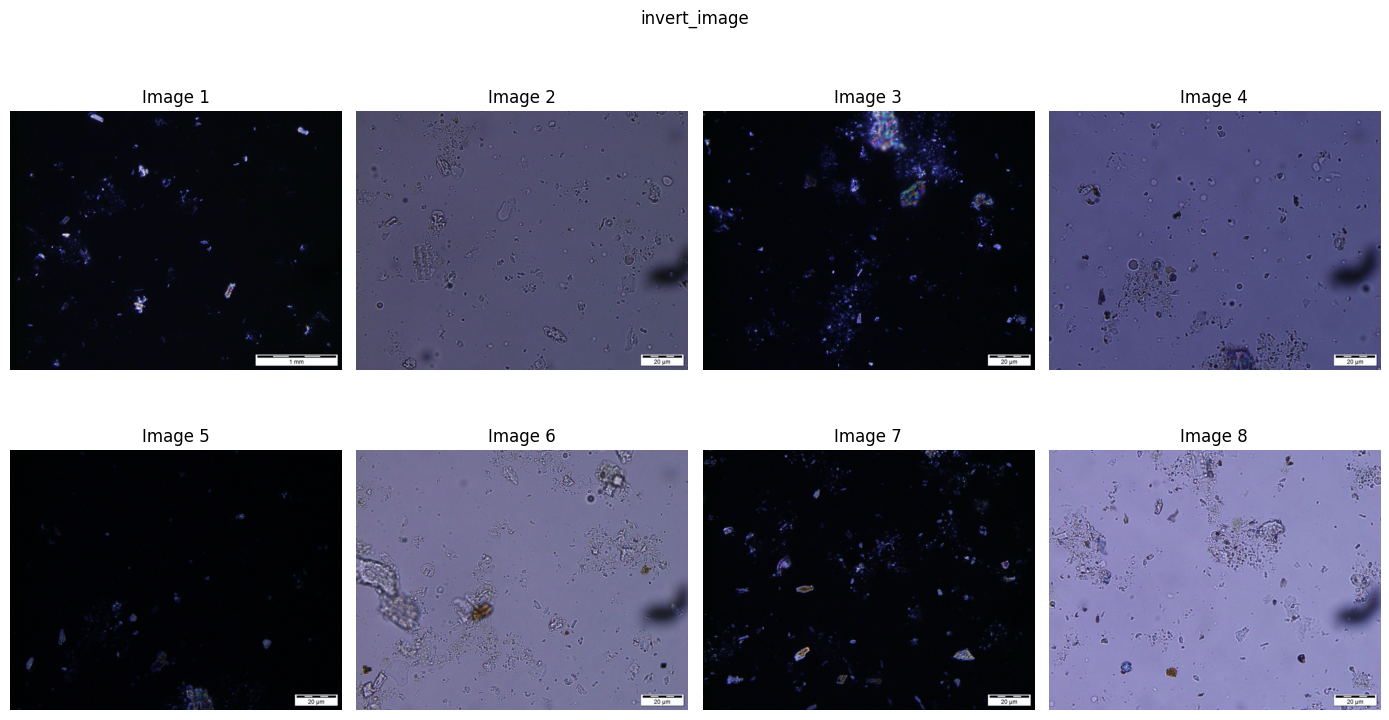

In [ ]:
show_images(Hres_ori_rgb_var,"invert_image")

In [ ]:
# Membuat variabel yang berbeda pada setiap iterasi
invert_image_varString = []
for i in range(287):
  Hres = Hres_ori_rgb_var[i]
  globals()[f"invert_image_Img{i+1}"] = invert_image(Hres)
  invert_image_varString.append("invert_image_Img"+str(i+1))
# Mengubah setiap string menjadi array
invert_image_var = [eval(string) for string in invert_image_varString]

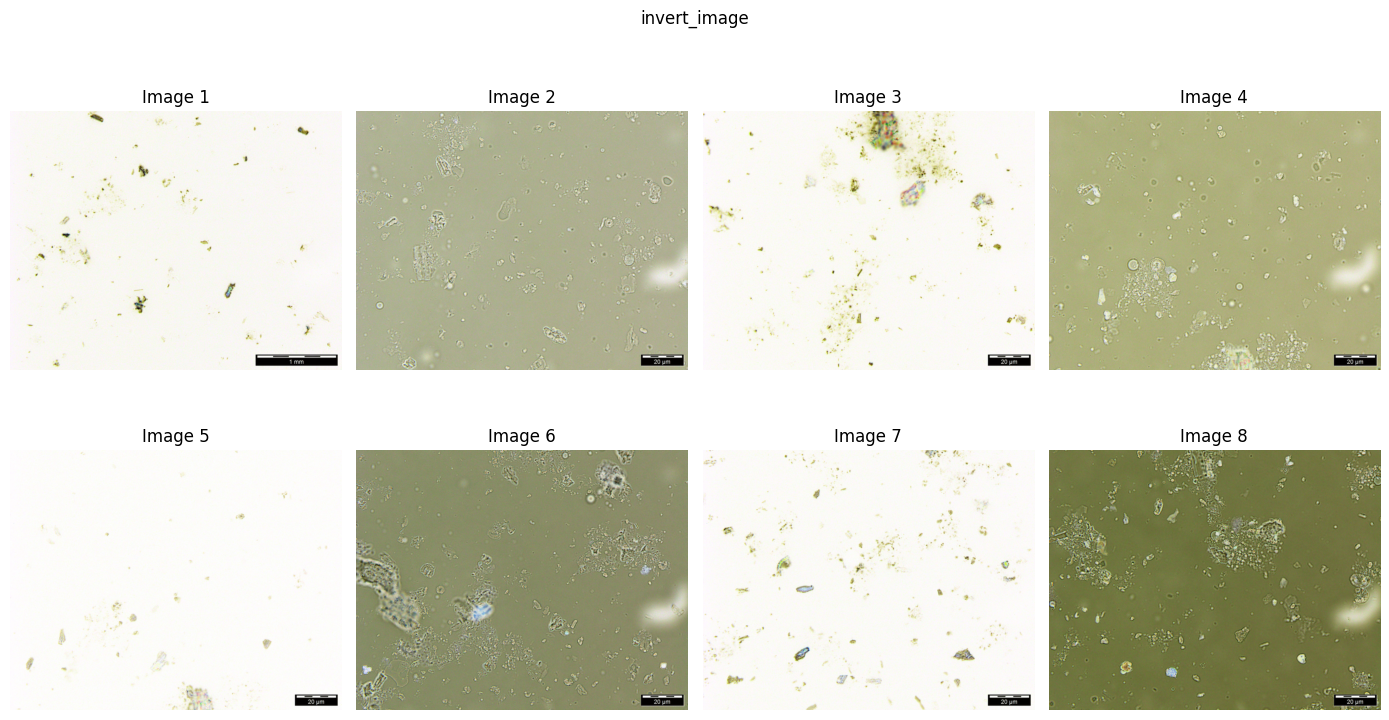

In [ ]:
show_images(invert_image_var,"invert_image")

#MeanSTD Contrast Stratching

In [ ]:
def stretch(img,sigma =3,plot_hist=False):
    stretched = np.zeros(img.shape)
    for i in range(img.shape[2]):  #looping through the bands
        band = img[:,:,i] # copiying each band into the variable `band`
        if np.min(band)<0: # if the min is less that zero, first we add min to all pixels so min becomes 0
            band = band + np.abs(np.min(band))
        band = band / np.max(band)
        band = band * 255 # convertaning values to 0-255 range
        if plot_hist:
            plt.hist(band.ravel(), bins=256) #calculating histogram
            plt.show()
        # plt.imshow(band)
        # plt.show()
        std = np.std(band)
        mean = np.mean(band)
        max = mean+(sigma*std)
        min = mean-(sigma*std)
        band = (band-min)/(max-min)
        band = band * 255
        # this streching cuases the values less than `mean-simga*std` to become negative
        # and values greater than `mean+simga*std` to become more than 255
        # so we clip the values ls 0 and gt 255
        band[band>255]=255
        band[band<0]=0
        print('band',i,np.min(band),np.mean(band),np.std(band),np.max(band))
        if plot_hist:
            plt.hist(band.ravel(), bins=256) #calculating histogram
            plt.show()
        stretched[:,:,i] = band
    stretched = stretched.astype('int')
    return stretched

##Purpose Method

In [ ]:
# Fungsi untuk menentukan apakah citra dominan gelap atau terang
def adaptiveInvertContrastStratching(image):
    # Menghitung rata-rata pixel
    average_pixel_value = np.mean(image)

    # Menentukan dominasi gelap atau terang
    if average_pixel_value < 90:
        img_rgb = image
        invert_image_Img = invert_image(img_rgb)
        result = stretch(invert_image_Img)
    else:
        result = stretch(image)

    return result


In [ ]:
# Membuat variabel yang berbeda pada setiap iterasi
adaptiveInvertContrast_varString = []
for i in range(287):
  Hres = Hres_ori_rgb_var[i]
  globals()[f"adaptiveInvertContrast_Img{i+1}"] = adaptiveInvertContrastStratching(Hres)
  adaptiveInvertContrast_varString.append("adaptiveInvertContrast_Img"+str(i+1))
# Mengubah setiap string menjadi array
adaptiveInvertContrast_var = [eval(string) for string in adaptiveInvertContrast_varString]

band 0 0.0 130.36706893821548 17.755486839945416 143.14891674834783
band 1 0.0 130.38311963299535 17.5525564478745 145.65249309200638
band 2 0.0 130.3610276087689 21.785350607145993 153.17405561899807
band 0 0.0 128.7666266566028 28.41955030001422 255.0
band 1 0.0 128.85812495144964 28.288420896368777 255.0
band 2 0.0 127.9032525753396 31.813758073871917 255.0
band 0 0.0 129.90951751676326 23.3300082613267 143.50776348912723
band 1 0.0 129.9871501940744 23.376240920061424 146.15228888477546
band 2 0.0 129.85176000953146 29.752269451929784 152.8278270179614
band 0 0.0 126.37514527371434 29.76164118513179 255.0
band 1 0.0 126.34564031076555 29.85078680142754 255.0
band 2 0.0 127.95722840483973 33.518016670946814 255.0
band 0 0.0 129.7121211816126 13.703448857745867 135.93641504094546
band 1 0.0 129.71902312170138 14.314344209594744 137.61514408015697
band 2 0.0 129.80238622072207 18.781284533176247 143.7755482434112
band 0 0.0 127.28998699569146 35.607168748951224 255.0
band 1 0.0 127.16

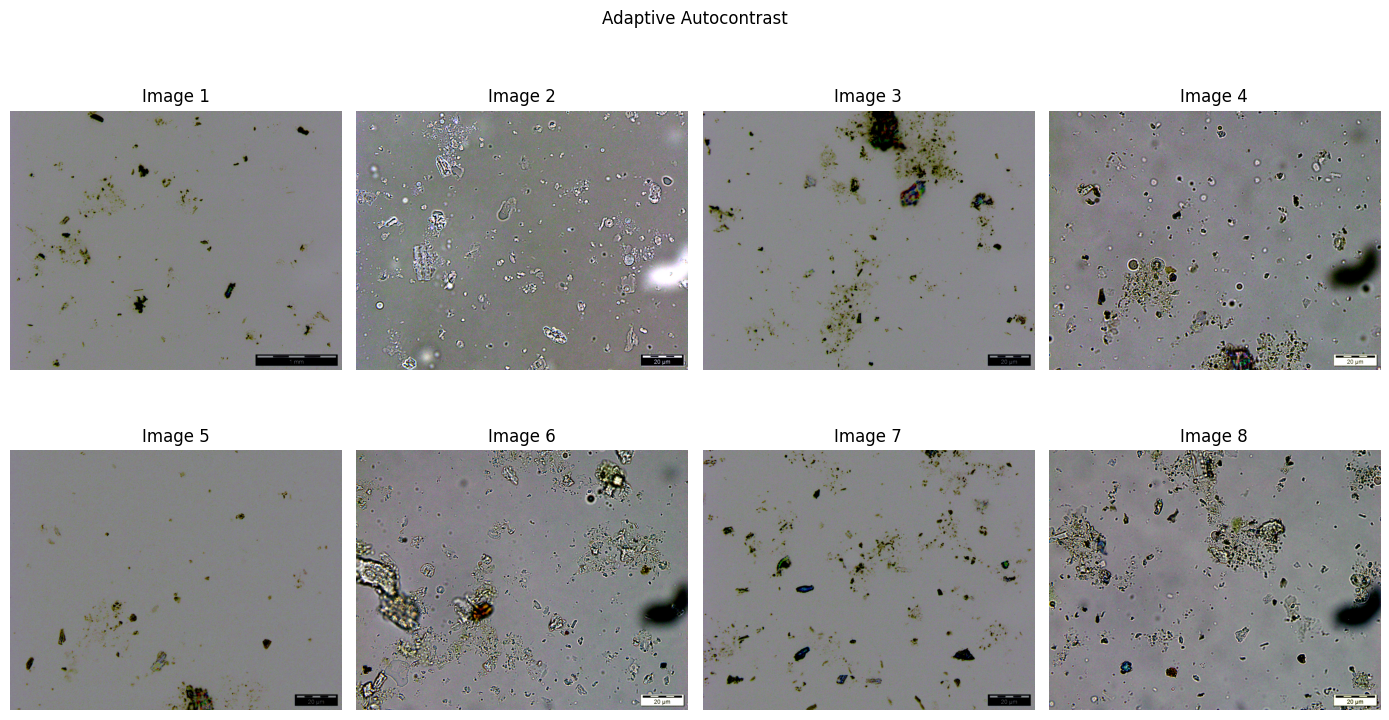

In [ ]:
show_images(adaptiveInvertContrast_var,"Adaptive Autocontrast")

##Save Image Proposed Method

In [ ]:
from PIL import Image
from numpy import asarray
output_MeanSTD_proposed = "/content/gdrive/MyDrive/Nannofossils_Dataset(1437)/Image_test_enhc/"
for i in range(287):
  image_MeanSTD_proposed = adaptiveInvertContrast_var[i]
  numpydata = asarray(image_MeanSTD_proposed)
  numpydata = numpydata.astype(np.uint8)
  image_MeanSTD_proposed2 = cv2.cvtColor(numpydata, cv2.COLOR_BGR2RGB)
  cv2.imwrite(f"{output_MeanSTD_proposed}image_MeanSTD_proposed({str(i+1)}).jpg",image_MeanSTD_proposed2)